# MLX

In [ ]:
!pip list

In [1]:
# import contextlib
# import copy
# import glob
# import importlib
# import json
# import logging
# import shutil
# import time
# from dataclasses import dataclass
from io import BytesIO
from pathlib import Path
# from textwrap import dedent
from typing import Any, Dict, Generator, List, Optional, Tuple, Union

# import mlx.core as mx
# import mlx.nn as nn
# import numpy as np
# import requests
# from huggingface_hub import snapshot_download
# from mlx.utils import tree_flatten, tree_reduce, tree_unflatten
from PIL import Image, ImageOps
# from transformers import (
#     AutoConfig,
#     AutoProcessor,
#     PreTrainedTokenizer,
#     PreTrainedTokenizerFast,
# )

In [2]:
from mlx_vlm import apply_chat_template, generate, load
# from mlx_vlm.utils import load_image

In [3]:
# model_id = "/Users/ljoana/repos/LLMs-Journey/VLMs/mlx_medgemma_4b_it_4bit"
model_id = "mlx-community/medgemma-4b-it-4bit"

In [4]:
model, processor = load(model_id)
config = model.config

/Users/ljoana/.pyenv/versions/ml/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
def load_image(image_source: Union[str, Path, BytesIO], timeout: int = 10):
    """
    Helper function to load an image from either a URL or file.
    """
    if isinstance(image_source, BytesIO) or Path(image_source).is_file():
        # for base64 encoded images
        try:
            image = Image.open(image_source)
        except IOError as e:
            raise ValueError(
                f"Failed to load image from {image_source} with error: {e}"
            ) from e
    elif image_source.startswith(("http://", "https://")):
        try:
            response = requests.get(image_source, stream=True, timeout=timeout)
            response.raise_for_status()
            image = Image.open(response.raw)
        except Exception as e:
            raise ValueError(
                f"Failed to load image from URL: {image_source} with error {e}"
            ) from e
    else:
        raise ValueError(
            f"The image {image_source} must be a valid URL or existing file."
        )

    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image

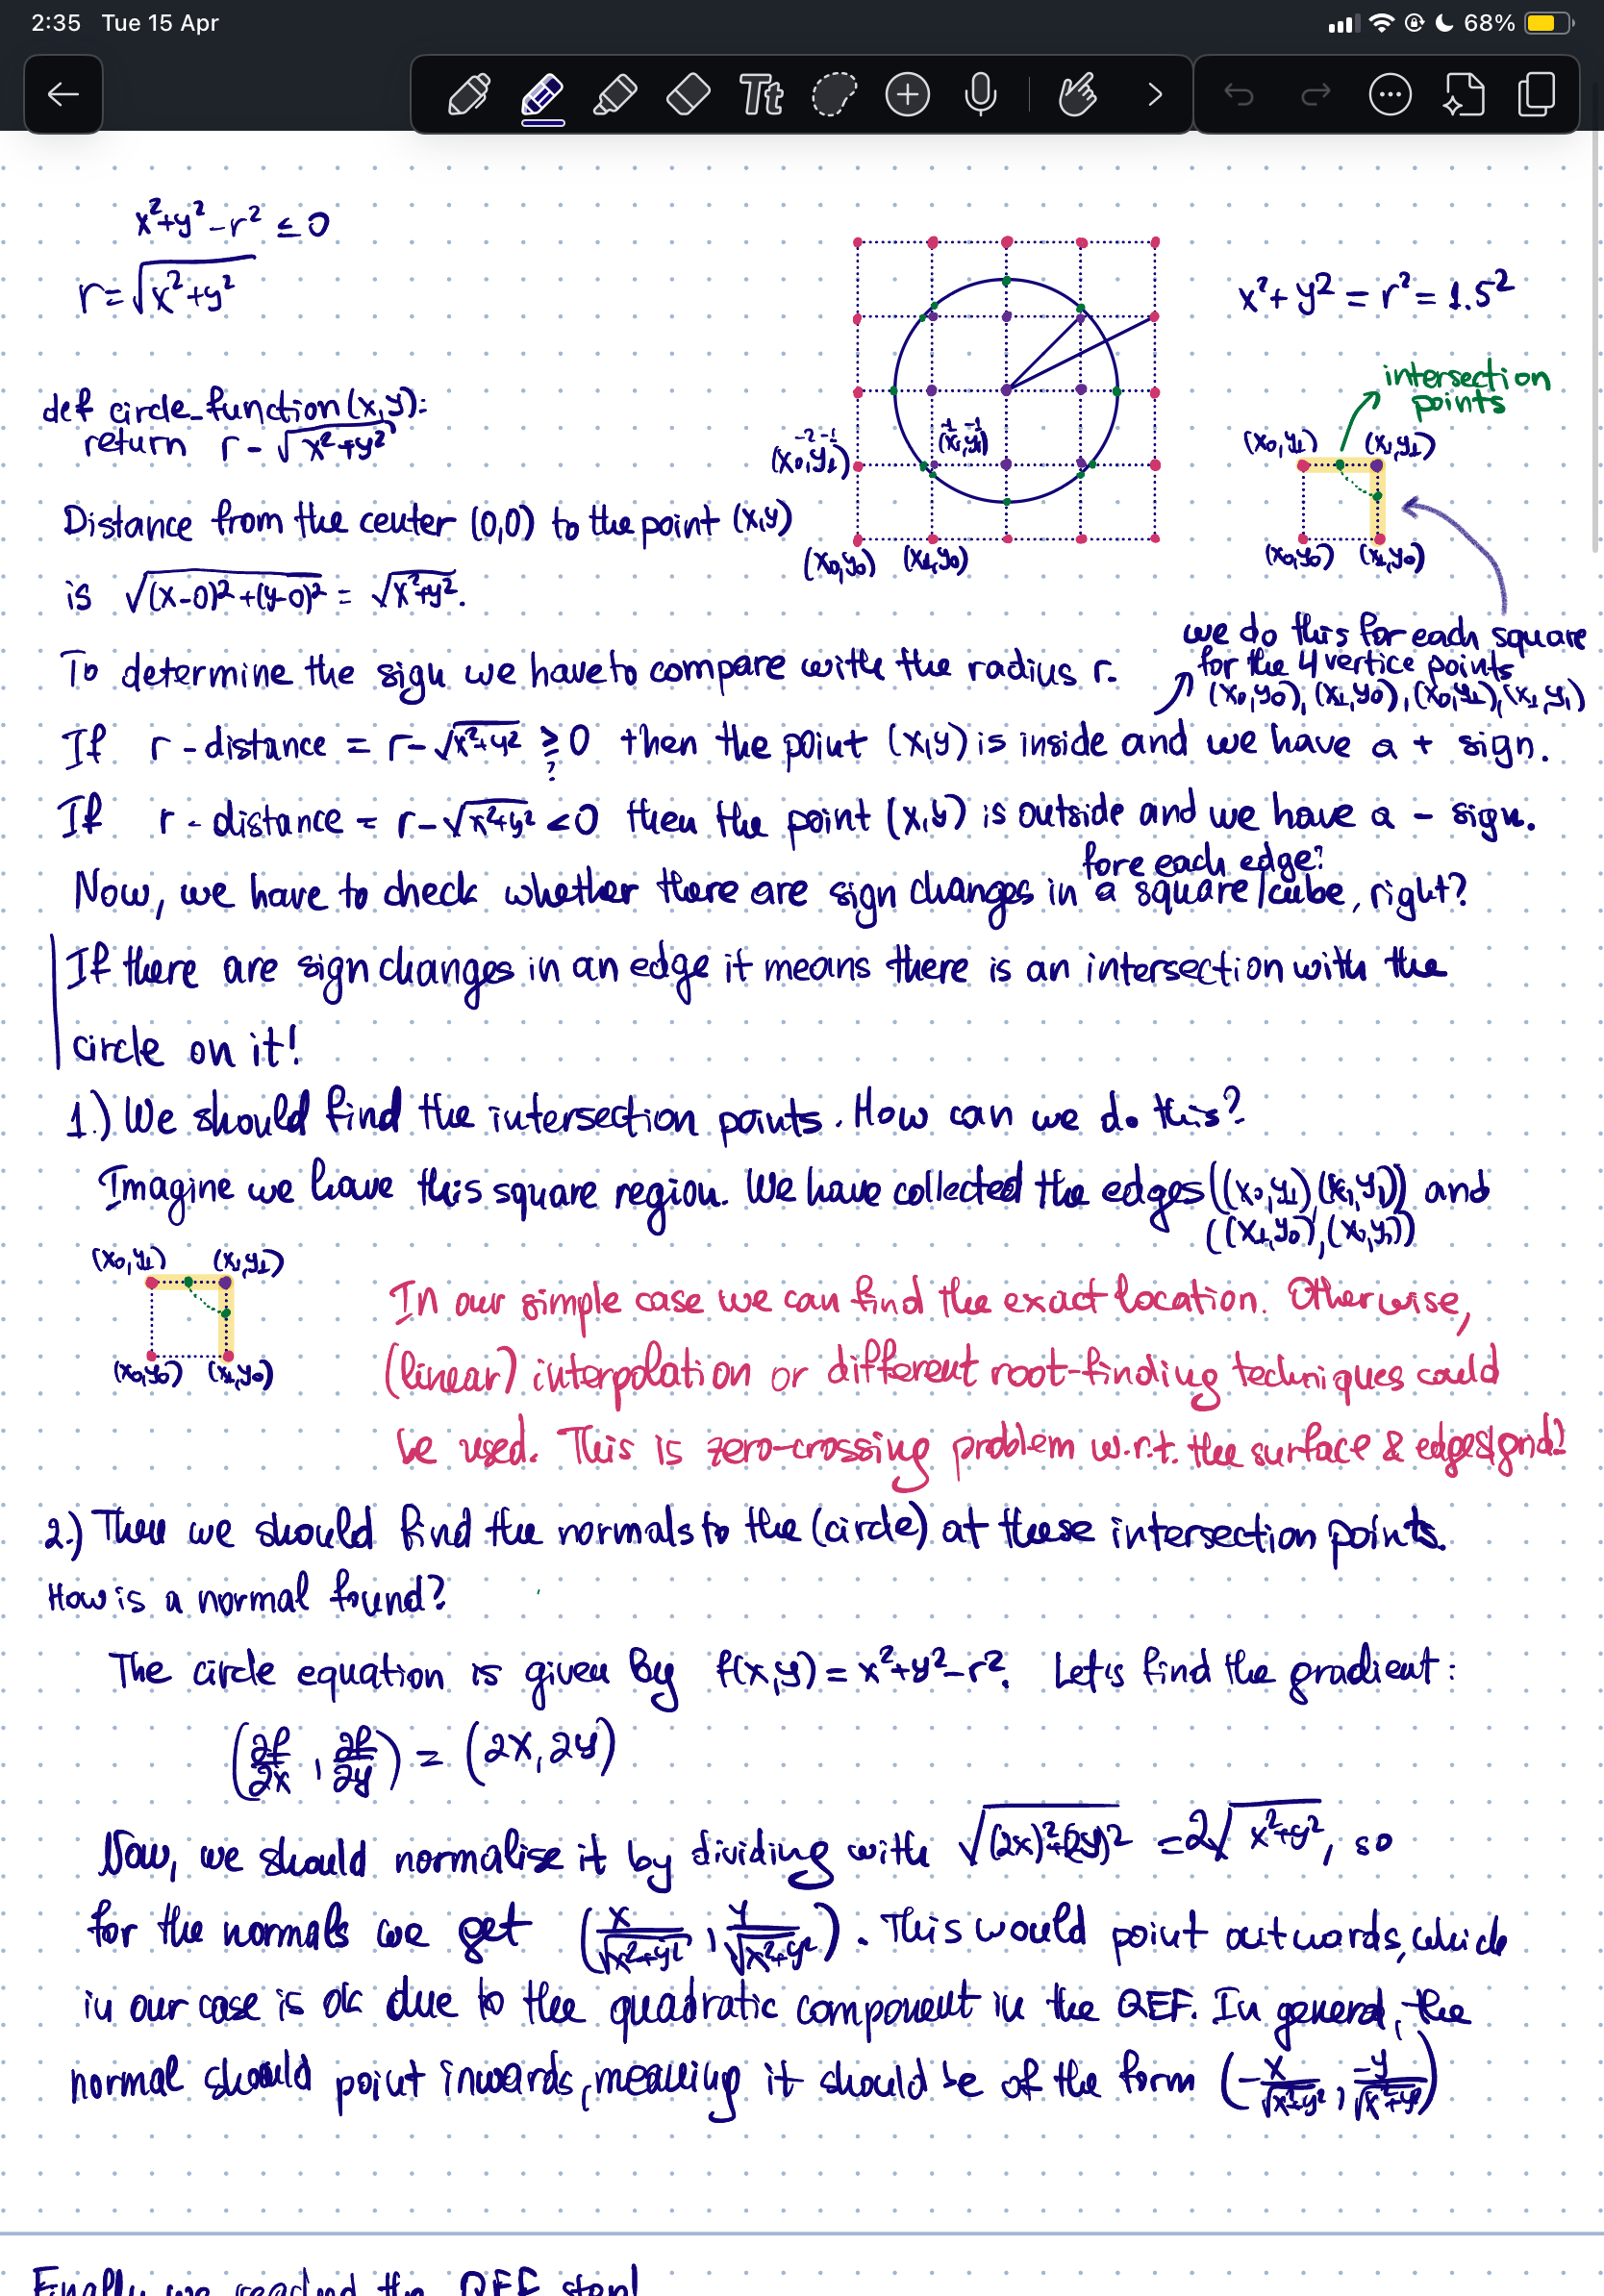

In [6]:
# image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
image_url = "/Users/ljoana/repos/LLMs-Journey/VLMs/IMG_2463.PNG.png"
image = load_image(image_url)
image

In [7]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this X-ray"}
        ]
    }
]

In [8]:
formatted_prompt = apply_chat_template(
    processor, config, messages, num_images=1
)

ValueError: Cannot use apply_chat_template because this processor does not have a chat template.

In [ ]:
response, metrics = generate(model, processor, formatted_prompt, image, verbose=True)

In [ ]:
print(response)

In [ ]:
print(metrics)

# Transformers

In [ ]:
import matplotlib.pyplot as plt
import requests
import torch
from PIL import Image
from transformers import AutoModelForImageTextToText, AutoProcessor

In [ ]:
model_id = "google/medgemma-4b-it"

In [ ]:
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
image = Image.open(requests.get(image_url, headers={"User-Agent": "example"}, stream=True).raw)

In [ ]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe this X-ray"},
            {"type": "image", "image": image},
        ]
    }
]

In [ ]:
inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

In [ ]:
# Get the pixel values and move to CPU if they're on GPU
img = inputs["pixel_values"][0].float().cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

# The pixel values are in shape (batch_size, channels, height, width)
# We need to transpose them to (height, width, channels) for plotting
# img = pixel_values[0].transpose(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=200, do_sample=False)
    generation = generation[0][input_len:]

In [ ]:
decoded = processor.decode(generation, skip_special_tokens=True)
print(decoded)